# Overfitting and Regularization

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import mean_squared_error
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer

In [3]:
set_config(display='diagram')

## Settings

In [4]:
SEED = 42
RANGE = (-5, 5)
N_SAMPLES = 50
DEGREES = np.linspace(0, 15, 1 + 15, dtype=int)
ALPHAS = np.linspace(0, 0.5, 1 + 40)

## Part 1: Underfitting vs. overfitting

### Generate samples

Let's pick a target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ and generate some noisy samples to learn from.

In [5]:
def target_function(x):
    return 2 * x + 10 * np.sin(x)

def generate_samples():
    """Generate noisy samples."""
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    y = target_function(x) + np.random.normal(scale=4, size=N_SAMPLES)
    return x.reshape(-1, 1), y

X, y = generate_samples()

### Plot samples

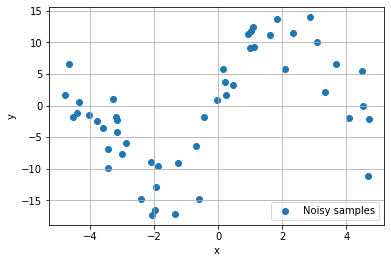

In [6]:
def plot_scatter(x, y, title=None, label='Noisy samples'):
    plt.scatter(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)
    plt.title(title)
    plt.legend(loc='lower right')

plot_scatter(X, y)

### Split

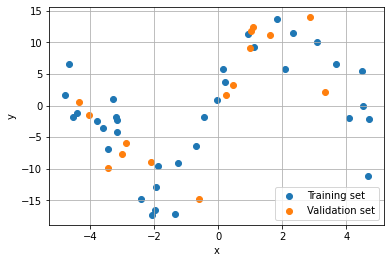

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

plot_scatter(X_train, y_train, label='Training set')
plot_scatter(X_valid, y_valid, label='Validation set')

In [8]:
display(y_train)

array([ -1.10771616,   0.84986647,  -9.62110024,   3.70972424,
        -2.36319095,   5.83708039, -16.53330524,  -1.8815588 ,
       -11.1506254 ,   1.0883081 ,  -9.05957818, -14.72254274,
         5.71746212,   5.48508317,  -6.81897956,  -1.80751907,
        -2.14124891, -12.83476672,  -0.09034969,  -3.48222266,
        11.50001273,  -2.03019037,  10.03142993, -17.18409407,
        -2.48182149,   1.67461593, -17.32081894,  -6.32825039,
        -4.15121484,   9.31494651,   6.5817456 ,   6.58351686,
        -1.83803375,  11.27589865,  13.68530977])

### Model

Let's try to approximate our target function $ f(x) = 2\cdot x + 10\cdot sin(x) $ with polynomials of different degree. 

A polynomial of degree $n$ has the form:
$ h(x) = w_0 + w_1\cdot x + w_2\cdot x^2 +\ldots + w_n\cdot x^n $.

$x^i$ values could easily be generated by `PolynomialFeatures`, while $w_i$ are the unknown paramaters to be estimated using `LinearRegression`.

In [9]:
PolynomialFeatures(degree=4, include_bias=False).fit_transform(X=[
    [1],
    [3],
    [4],
])

array([[  1.,   1.,   1.,   1.],
       [  3.,   9.,  27.,  81.],
       [  4.,  16.,  64., 256.]])

In [10]:


def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    
    
    return Pipeline([
        ('pol', PolynomialFeatures(degree, include_bias=(degree == 0))),
        ('sca', StandardScaler()),
        ('reg', regressor)
    ])

display(make_model(2))
display(make_model(2, penalty='L1', alpha=0.1))
display(make_model(2, penalty='L2', alpha=0.1))

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()), ('reg', LinearRegression())])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Lasso(alpha=0.1, max_iter=50000, random_state=42))])

Pipeline(steps=[('pol', PolynomialFeatures(include_bias=False)),
                ('sca', StandardScaler()),
                ('reg', Ridge(alpha=0.1, max_iter=50000, random_state=42))])

### Fit

Let's fit a model and plot the hypothesis it learns:

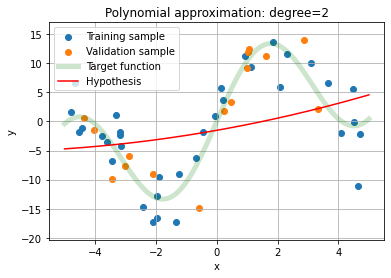

In [11]:
def plot_fit(model):
    degree = model['pol'].degree
    X_range = np.linspace(*RANGE, 1000).reshape(-1, 1)
    y_pred = model.predict(X_range)
    plot_scatter(X_train, y_train, label='Training sample')
    plot_scatter(X_valid, y_valid, label='Validation sample')
    plt.plot(X_range, target_function(X_range), c='green', alpha=0.2, lw=5, label='Target function')
    plt.plot(X_range, y_pred, c='red', label='Hypothesis')
    plt.ylim((min(y) - 3, max(y) + 3))
    plt.legend(loc='best')    
    plt.title(f'Polynomial approximation: degree={degree}')
    plt.show()

plot_fit(make_model(degree=2).fit(X_train, y_train))

### From underfitting to overfitting

We can investigate the shape of the fitted curve for different values of `degree`:

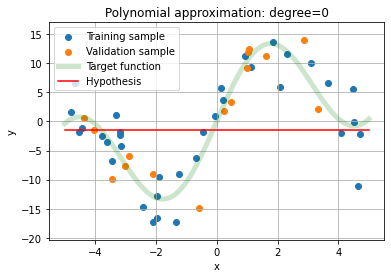

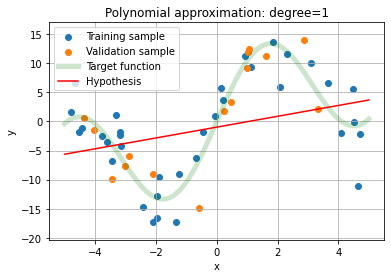

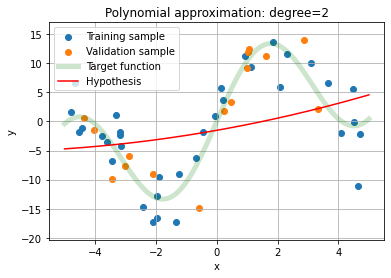

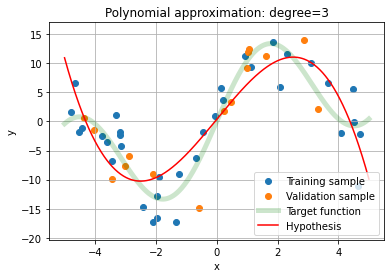

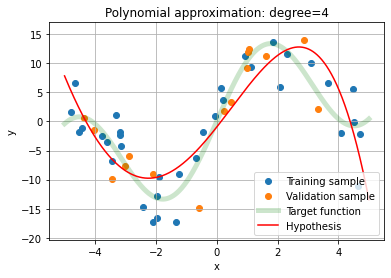

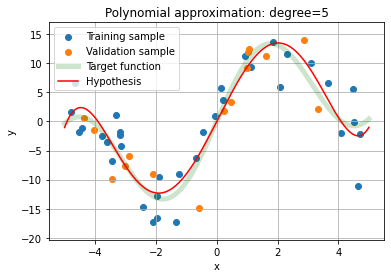

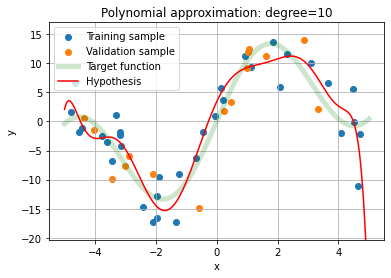

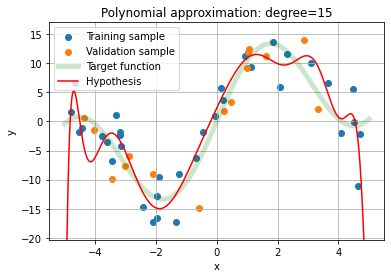

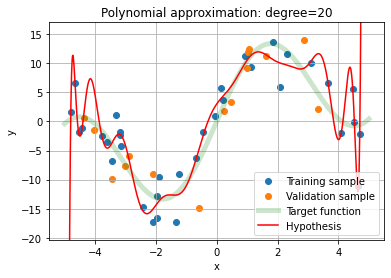

In [12]:
for degree in [0, 1, 2, 3, 4, 5, 10, 15, 20]:
    plot_fit(make_model(degree).fit(X_train, y_train))

### Fitting graph

In the next step we calculate the training and the validation error for each `degree` and plot them in a single graph. The resulting graph is called the fitting graph.

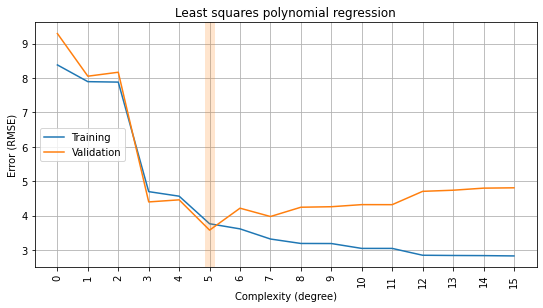

In [13]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def plot_fitting_graph(x, metric_train, metric_valid, xlabel, ylabel, 
                       custom_metric=None, custom_label='', custom_scale='log', title='Fitting graph'):
    plt.figure(figsize=(9, 4.5))
    plt.plot(x, metric_train, label='Training')
    plt.plot(x, metric_valid, color='C1', label='Validation')
    plt.axvline(x[np.argmin(metric_valid)], color='C1', lw=10, alpha=0.2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.xticks(x, rotation='vertical')
    plt.legend(loc='center left')        
    if custom_metric:
        plt.twinx()
        plt.yscale(custom_scale)
        plt.plot(x, custom_metric, alpha=0.2, lw=4, ls='dotted', color='black', label=custom_label) 
        plt.legend(loc='center right')         
    plt.show()
    
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

### Sweet spot

What is the optimal `degree` to go with?

In [14]:
DEGREES[np.argmin(rmse_valid)]

5

### Cross-validation

Ideally, we would choose the the model parameters such that we have the best model performance. However, we want to make sure that we really have the best validation performance. When we do `train_test_split` we randomly split the data into two parts. What could happen is that we got lucky and split the data such that it favours the validation error. This is especially dangerous if we are dealing with small datasets. One way to check if that's the case is to run the experiment several times for different, random splits. However, there is an even more systematic way of doing this: [cross-validation](https://scikit-learn.org/stable/modules/cross_validation.html).

<img src="https://scikit-learn.org/stable/_images/grid_search_cross_validation.png" width=50% />

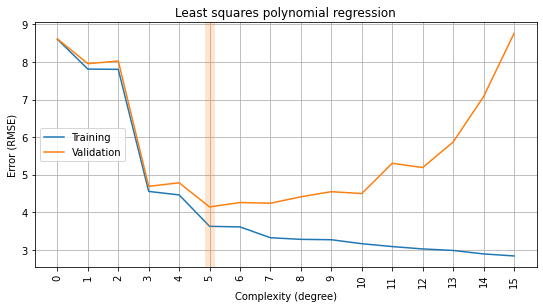

In [15]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

### Model coefficients

Let's inspect our regression model coefficients:

In [16]:
(make_model(degree=1).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=2).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=5).fit(X_train, y_train)['reg'].coef_,
 make_model(degree=10).fit(X_train, y_train)['reg'].coef_)

(array([2.81292778]),
 array([2.80049884, 0.45166501]),
 array([ 30.87315584,   1.48752361, -54.60227825,  -1.63699842,
         26.62792933]),
 array([  33.63850705,  -41.86346242,  -70.48743112,  278.98853452,
          27.48125634, -656.36383501,   59.32988346,  651.64795186,
         -47.55728814, -233.48455138]))

Hmm... it looks like high degree polynomials are coming with much bigger regression coefficients. 

We are going to plot the mean absolute value of $w_i$ as a function of degree to reveal the relationship:

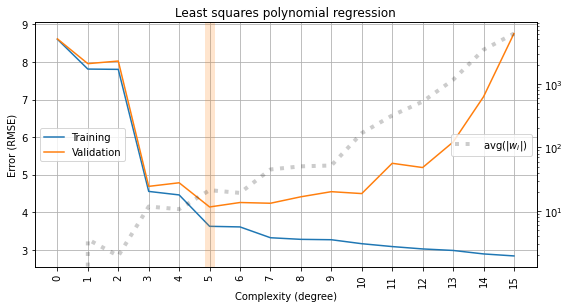

In [17]:
rmse_train, rmse_valid, avg_coef = [], [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree),
                             X, y, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))        
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid,
                   xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Least squares polynomial regression')

### Summary

We observe the following:

1. **Underfitting** (degree < 5): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. **Fit is just right** (degree = 5): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. **Overfitting** (degree > 5): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

4. As the order of polynomial increases, the linear model coefficients become more likely to take on **large values**.

## Part 2: Regularization

There are two major ways to build a machine learning model with the ability to generalize well on unseen data:
1. Train the simplest model possible for our purpose (according to Occam’s Razor).
2. Train a complex or more expressive model on the data and perform regularization.

Regularization is a method used to reduce the variance of a machine learning model. In other words, it is used to reduce overfitting. Regularization penalizes a model for being complex. For linear models, it means regularization forces model coefficients to be smaller in magnitude.

Let's pick a polynomial model of degree **15** (which tends to overfit strongly) and try to regularize it using **L1** and **L2** penalties.

### L1 - Lasso regression

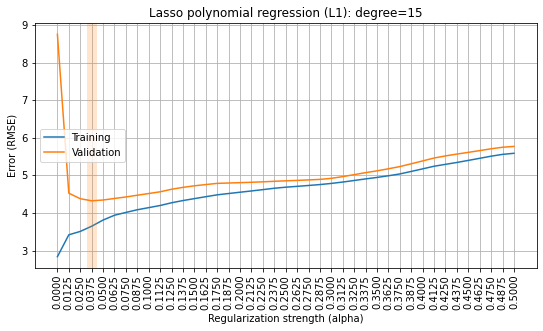

In [18]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   title='Lasso polynomial regression (L1): degree=15')

### L2 - Ridge regression

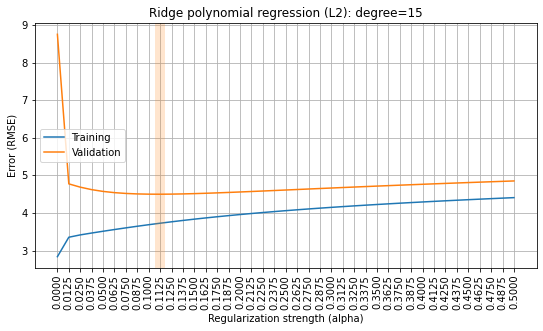

In [19]:
rmse_train, rmse_valid = [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X, y, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid, 
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)', 
                   title='Ridge polynomial regression (L2): degree=15')

### Summary

1. We can control the regularization strength by changing the hyperparameter `alpha`.
2. Regularized version of the model performs pretty well. Even in case the original original (unregularized) model is heavily overfitting due to excessive complexity.

## Part 3: Homework assignment (10 points)

**WARNING!**

Due to the limited power of your machine, you may face some difficulties in generating polynomial features of a high degree. It's ok to take only a subsample of features for that purpose (even one feature is enough). Afterwards, you **must collect all features together** (those which were used to generate polynomials and the rest).

### Excercise 1 - Overfiting and Underfitting (2 points)

Let's work with the diabetes dataset

In [20]:
from sklearn.datasets import load_diabetes
data = load_diabetes()
X_diabetes = pd.DataFrame(data['data'], columns=data['feature_names'])
y_diabetes = pd.DataFrame(data['target'], columns=['target'])
print(data['DESCR'])
set_config(display='text')

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - age     age in years
      - sex
      - bmi     body mass index
      - bp      average blood pressure
      - s1      tc, total serum cholesterol
      - s2      ldl, low-density lipoproteins
      - s3      hdl, high-density lipoproteins
      - s4      tch, total cholesterol / HDL
      - s5      ltg, possibly log of serum triglycerides level
      - s6      glu, blood sugar level

Note: Each of these 1

Apply model for diabetes dataset with polynomial feature engineering of different degrees. Plot the dependence of train and test error on polynomial degree. Highlight a degree with the best test error. Which degrees cause overfitting/underfitting? Why?

In [21]:
X_train, X_valid, y_train, y_valid = train_test_split(X_diabetes, y_diabetes, test_size=0.3, random_state=0)
display(X_train)

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
232,0.012648,0.050680,0.000261,-0.011409,0.039710,0.057245,-0.039719,0.056081,0.024053,0.032059
224,-0.027310,-0.044642,-0.066563,-0.112400,-0.049727,-0.041397,0.000779,-0.039493,-0.035817,-0.009362
252,0.005383,-0.044642,0.059541,-0.056166,0.024574,0.052861,-0.043401,0.050914,-0.004220,-0.030072
254,0.030811,0.050680,0.056307,0.076958,0.049341,-0.012274,-0.036038,0.071210,0.120053,0.090049
418,0.009016,-0.044642,-0.024529,-0.026328,0.098876,0.094196,0.070730,-0.002592,-0.021394,0.007207
...,...,...,...,...,...,...,...,...,...,...
323,0.070769,0.050680,-0.007284,0.049415,0.060349,-0.004445,-0.054446,0.108111,0.129019,0.056912
192,0.056239,0.050680,-0.030996,0.008101,0.019070,0.021233,0.033914,-0.039493,-0.029528,-0.059067
117,0.059871,-0.044642,-0.021295,0.087287,0.045213,0.031567,-0.047082,0.071210,0.079121,0.135612
47,-0.078165,-0.044642,-0.073030,-0.057314,-0.084126,-0.074277,-0.024993,-0.039493,-0.018118,-0.083920


Selected feature for polynomial transformasion is 'age'.

In [22]:
pol_features = ['age']

New make_model function to apply polynomial transformation on a subset of features.

In [23]:
def make_model(degree, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    preprocessor = make_column_transformer(
            (PolynomialFeatures(degree, include_bias=(degree==0)), pol_features),
            remainder='passthrough'
    )
    return Pipeline([
        ('pre', preprocessor),
        ('reg', regressor)
    ])
display(make_model(2))

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('polynomialfeatures',
                                                  PolynomialFeatures(include_bias=False),
                                                  ['age'])])),
                ('reg', LinearRegression())])

In [24]:
DEGREES = np.linspace(1, 15, 15, dtype=int)
display(DEGREES)

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

Plots of error vs. polynomial degree with and without cross validation.

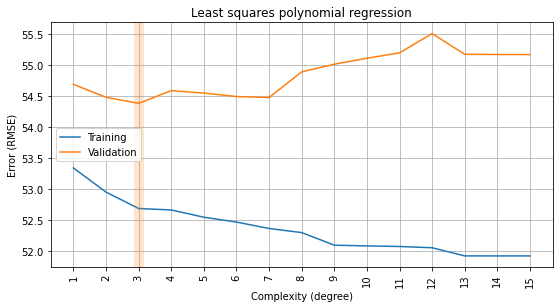

In [25]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    results = cross_validate(make_model(degree), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)',
                   title='Least squares polynomial regression')

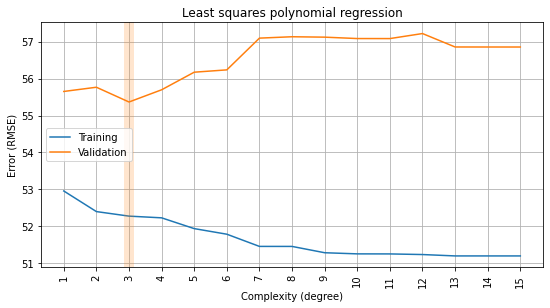

In [26]:
rmse_train, rmse_valid = [], []
for degree in DEGREES:
    reg = make_model(degree).fit(X_train, y_train)
    rmse_train.append(rmse(reg.predict(X_train), y_train))
    rmse_valid.append(rmse(reg.predict(X_valid), y_valid))
    
plot_fitting_graph(DEGREES, rmse_train, rmse_valid, xlabel='Complexity (degree)', ylabel='Error (RMSE)', 
                   title='Least squares polynomial regression')

In [27]:
display(DEGREES[np.argmin(rmse_valid)])

3

In [28]:
reg = make_model(3).fit(X_train, y_train)
display(reg['reg'].coef_)

array([[    87.07463297,   2832.53751947, -23865.77950614,
          -190.82073186,    597.79598757,    278.74608017,
          -638.96353888,    343.4445048 ,     28.74994404,
           145.64600845,    761.31769647,     32.6515713 ]])

In [29]:
# your findings/conclusions

The best test errore degree for age feature is 3. Degrees less than 3 cause underfitting and degrees greater than 3 cause overfitting.
We observe the following:

1. Underfitting (degree < 3): The model is not able to fit the data properly. The fit is bad for both the training and the validation set.

2. Fit is just right (degree = 3): The model is able to capture the underlying data distribution. The fit is good for both the training and the validation set.

3. Overfitting (degree > 3): The model starts fitting the noise in the dataset. While the fit for the training data gets even better, the fit for the validation set gets worse.

### Excercise 2 - Magnitude (3 points)

As discussed earlier, regularization methods are expected to constraint the weights (model coefficients). 

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Lets see the dependence between alpha value and model coefficients.

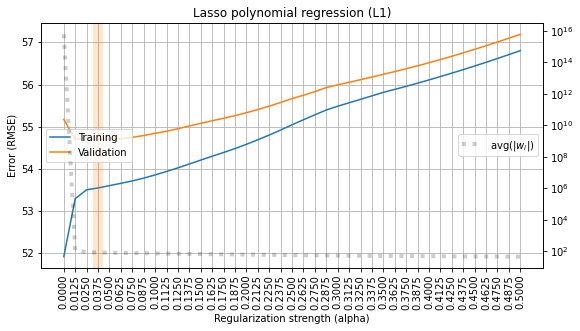

In [30]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')

We can see that model with alpha equals 0 has much bigger coefficients. Now, lets see same plot without zero alpha value.

In [31]:
ALPHAS_nonzero = np.linspace(0.0125, 0.5, 40)
display(ALPHAS_nonzero)

array([0.0125, 0.025 , 0.0375, 0.05  , 0.0625, 0.075 , 0.0875, 0.1   ,
       0.1125, 0.125 , 0.1375, 0.15  , 0.1625, 0.175 , 0.1875, 0.2   ,
       0.2125, 0.225 , 0.2375, 0.25  , 0.2625, 0.275 , 0.2875, 0.3   ,
       0.3125, 0.325 , 0.3375, 0.35  , 0.3625, 0.375 , 0.3875, 0.4   ,
       0.4125, 0.425 , 0.4375, 0.45  , 0.4625, 0.475 , 0.4875, 0.5   ])

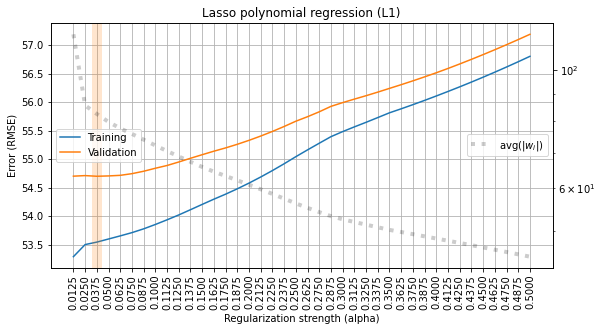

In [32]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS_nonzero:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS_nonzero, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')

From that, we can see that model coefficients decreases as alpha value increases. Lasso regularization constraints weight values.

#### L2

Lets draw same two plots for Ridge Regression.

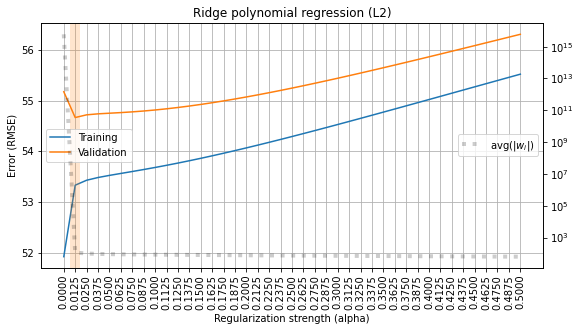

In [33]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2)')

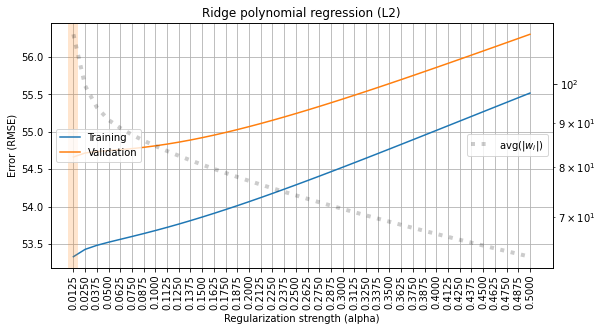

In [34]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS_nonzero:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS_nonzero, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2)')

We can see the same results here: zero alpha model has bigger coefficients, and their value decreases as alpha value increases. Weights are constrained by Ridge Regression too.

#### Summary

In [35]:
## your observations/conclusions

Both models constraint weight values, and they tend to decrease as alpha value of regularizations increase. Also, model with zero alpha (just Linear Regression) has much bigger coefficients.

### Excercise 3 - Sparsity (3 points)

Lasso can also be used for **feature selection** since L1 is [more likely to produce zero coefficients](https://explained.ai/regularization/).

Is it indeed happening? 

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**). Let's use `degree=15` and `alpha` from `ALPHAS`.

#### L1

Lets discover the minimum absolute values of coefficients for different values of alpha and draw a plot.

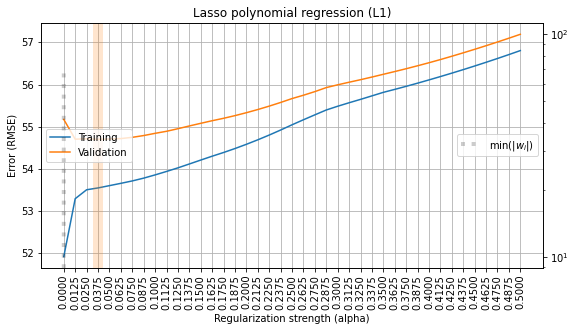

[66.68456972233034,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [36]:
## your code
rmse_train, rmse_valid, min_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L1', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    min_coef.append(        
        # average over CV folds
        np.mean([            
            # minimum absolute value of weights
            np.min(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=min_coef, custom_label='min(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')
display(min_coef)

We see that the minimum value of weights for all alpha values, except alpha equals zero, take zero values.

#### L2

Lets do the same thing for Ridge Regression.

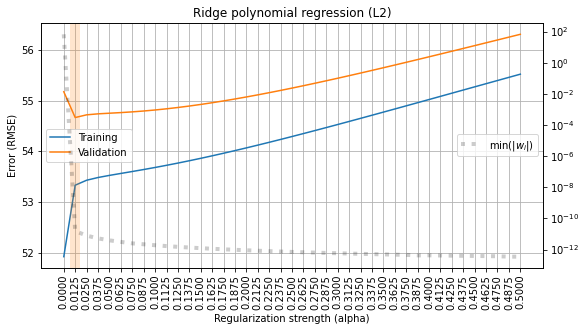

[66.68456972233034,
 1.541134805819912e-11,
 7.837145922277159e-12,
 5.2209116059560505e-12,
 3.894694913069483e-12,
 3.093958699370567e-12,
 2.493843435745301e-12,
 2.176207161925349e-12,
 1.8895623456678706e-12,
 1.6670182251003648e-12,
 1.4894300349399243e-12,
 1.344574356670477e-12,
 1.2242814463067912e-12,
 1.12288418044989e-12,
 1.0363284961384731e-12,
 9.616380336540914e-13,
 8.965786838391638e-13,
 8.394410597293423e-13,
 7.888952084492095e-13,
 7.438910447255373e-13,
 7.035885581229163e-13,
 6.673079014821751e-13,
 6.344930540343701e-13,
 6.04684939678012e-13,
 5.775012501631503e-13,
 5.526211006156948e-13,
 5.297732195166221e-13,
 5.087267588597532e-13,
 4.892840708193402e-13,
 4.712749771778309e-13,
 4.5455218382901547e-13,
 4.218450014750831e-13,
 4.261257610190188e-13,
 4.1535761930603354e-13,
 4.052768844427216e-13,
 3.958217128871481e-13,
 3.869372791480169e-13,
 3.785748191148326e-13,
 3.706908249560069e-13,
 3.4984449295173307e-13,
 3.4777004038279695e-13]

In [37]:
## your code
rmse_train, rmse_valid, min_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(degree=15, penalty='L2', alpha=alpha), 
                             X_diabetes, y_diabetes, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    min_coef.append(        
        # average over CV folds
        np.mean([            
            # minimum absolute value of weights
            np.min(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=min_coef, custom_label='min(|$w_i$|)',
                   title='Ridge polynomial regression (L2)')
display(min_coef)

We see that minimum vales of weights for alphas bigger than zero are very close to zero (~10e-13), but not equal to that.

#### Summary

In [38]:
# your findings/conclusions

It can be seen that in L1 (Lasso) regularization coefficients can take zero values, while in L2 (Ridge) they can only take values very close to zero.

### Excercise 4 - Scaling (2 points)

As a general rule, it is recommended to scale input features before fitting a regularized model so that the features/inputs take values in similar ranges. One common way of doing so is to standardize the inputs and that is exactly what our pipeline  second step (`StandardScaler`) is responsible for. 

Is scaling important? What are the underlying reasons?

Please do a discovery on your own and find that out empirically (both for **L1** and **L2**) on the dataset below. Check coefficients.

In [39]:
def target_function_hw(x):
    return 2 * x

def generate_samples_hw():
    np.random.seed(SEED)
    x = np.random.uniform(*RANGE, size=N_SAMPLES)
    
    np.random.seed(SEED+1)
    x_noise = np.random.uniform(*[x * 100 for x in RANGE], size=N_SAMPLES)
    x_noise2 = np.random.normal(100, 50, size=N_SAMPLES)
    
    y = target_function_hw(x) + np.random.normal(scale=4, size=N_SAMPLES)
    
    return np.concatenate([x.reshape(-1, 1) / 100, 
                           x_noise.reshape(-1, 1),
                           x_noise2.reshape(-1, 1)], axis=1), y

X_hw, y_hw = generate_samples_hw()

for i in range(X_hw.shape[1]):
    print(f'Min of feature {i}: {min(X_hw[:, i]):.2f}, max: {max(X_hw[:, i]):.2f}')

Min of feature 0: -0.05, max: 0.05
Min of feature 1: -494.87, max: 493.57
Min of feature 2: -2.35, max: 213.31


In [40]:
def make_model(scaler, alpha=0, penalty=None):
    # linear regression
    if alpha == 0:
        regressor = LinearRegression()
    # lasso regression",
    elif penalty == 'L1':
        regressor = Lasso(alpha=alpha, random_state=SEED, max_iter=50000)
    # ridge regression",
    elif penalty == 'L2':
        regressor = Ridge(alpha=alpha, random_state=SEED, max_iter=50000) 
    if scaler: res = Pipeline([
            ('sca', StandardScaler()),
            ('reg', regressor)
        ])
    else: res = Pipeline([
            ('reg', regressor)
        ])
    return res

#### L1

We will chose new alpha values

In [41]:
ALPHAS = np.linspace(0, 2, 41)
display(ALPHAS)

array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
       0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  , 1.05,
       1.1 , 1.15, 1.2 , 1.25, 1.3 , 1.35, 1.4 , 1.45, 1.5 , 1.55, 1.6 ,
       1.65, 1.7 , 1.75, 1.8 , 1.85, 1.9 , 1.95, 2.  ])

Lets draw dependecies of error and coefficient values on alpha with and without scaler.

Firstly, lets check model with scaler.

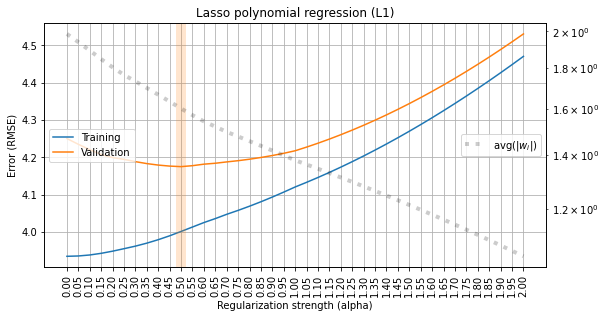

In [42]:
## your code
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(scaler=True, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1)')

Model looks pretty normal. It has optimal value for alpha (0.5), which is not equal to zero and coefficients are not close to zero too (~1.7 for alpha = 0.5).
Now lets look to the model without scaling.

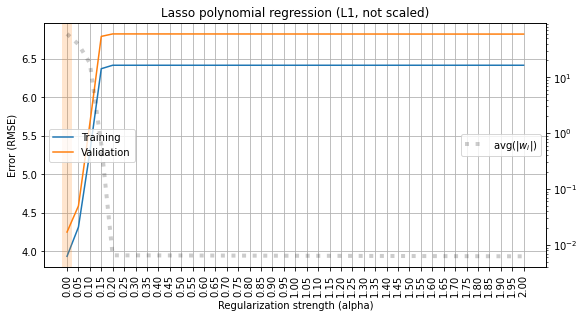

In [43]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(scaler=False, penalty='L1', alpha=alpha), 
                             X_hw, y_hw, cv=5,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Lasso polynomial regression (L1, not scaled)')

Oh no. We can see that the optimal alpha value is zero now. Also, coefficients quickly become close to zero and error value increases.

#### L2

Lets do the same things with Ridge Regression.

In [44]:
## your code
ALPHAS = np.linspace(0, 5, 41)
display(ALPHAS)

array([0.   , 0.125, 0.25 , 0.375, 0.5  , 0.625, 0.75 , 0.875, 1.   ,
       1.125, 1.25 , 1.375, 1.5  , 1.625, 1.75 , 1.875, 2.   , 2.125,
       2.25 , 2.375, 2.5  , 2.625, 2.75 , 2.875, 3.   , 3.125, 3.25 ,
       3.375, 3.5  , 3.625, 3.75 , 3.875, 4.   , 4.125, 4.25 , 4.375,
       4.5  , 4.625, 4.75 , 4.875, 5.   ])

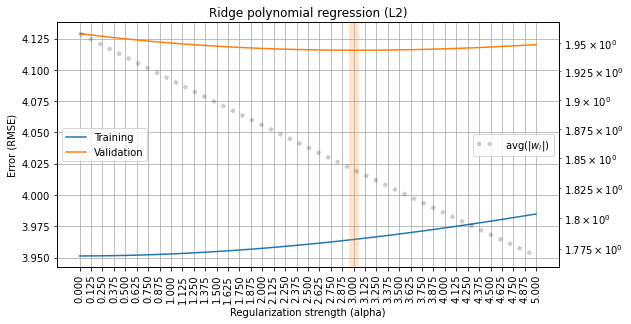

In [45]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(scaler=True, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=10,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2)')

Again, model looks fine. Optimal alpha (3.0) and coefficients are not zero.
Now lets look to the model without scaling.

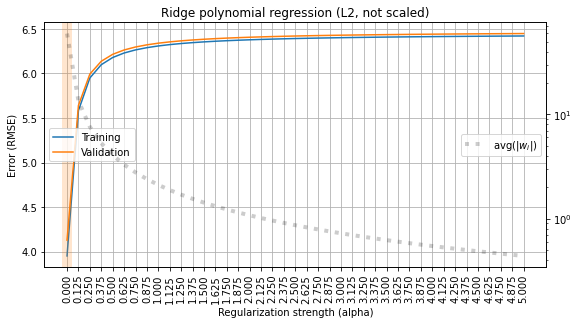

In [46]:
rmse_train, rmse_valid, avg_coef = [], [], []
for alpha in ALPHAS:    
    results = cross_validate(make_model(scaler=False, penalty='L2', alpha=alpha), 
                             X_hw, y_hw, cv=10,
                             return_train_score=True, return_estimator=True,
                             scoring='neg_root_mean_squared_error')
    rmse_train.append(-np.mean(results['train_score']))
    rmse_valid.append(-np.mean(results['test_score']))
    avg_coef.append(        
        # average over CV folds
        np.mean([            
            # mean absolute value of weights
            np.mean(np.abs(model['reg'].coef_))
            for model in results['estimator']
        ]))
    
plot_fitting_graph(ALPHAS, rmse_train, rmse_valid,
                   xlabel='Regularization strength (alpha)', ylabel='Error (RMSE)',
                   custom_metric=avg_coef, custom_label='avg(|$w_i$|)',
                   title='Ridge polynomial regression (L2, not scaled)')

Again, simmilar picture. Optimal alpha is zero, and coefficients approaches to zero.

#### Summary



In [47]:
## your observations/conclusions

With both regularizations, models without scaling have alpha values equal (or very close) to zero and coefficients approaching to zero. An explanation to this can be the fact that the noises (feature 1 and feature 2) had absolute values much greater than correlating feature (feature 0). Max absolute values for feature 1 is 495, for feature 2 is 213 and for feature zero just 0.05. Noises undermined correlating feature in the model, so it had coefficient with little value. Noises themselves were randomly generated and were not correlated with the output value, so penalty of regularization made them close to zero too. 